# Iterative Quantum Phase Estimation Algorithm

[ Intro ]

The goal of this tutorial is to understand how the IPE (Iterative Phase Estimation) algorithm works, how to build it and why would we use the IPE algorithm instead of the QPE (Quantum Phase Estimation) algorithm.

**References**

- [Ch.3.5 Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
- [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)


In [21]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, assemble, Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit import BasicAer
import numpy as np
import matplotlib.pyplot as plt

# C_if

The c_if gate, is a gate to perform conditioned operations based on the state of the classical register-

For example, the following code will execute the **X** gate if the measurement of the clasical register is **0** but not because the **0** arg is telling the function what does it want to compare, it is because the function c_if expects a quantum register and a binary encoded number. 

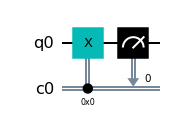

In [2]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)
qc.x(q[0]).c_if(c, 0)
qc.measure(q,c)
qc.draw(output='mpl')

So, let's image that we want to perform a bit flip on the first qbit on the following circuit when the measurement of q1 and q2 were both 1

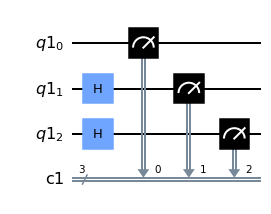

In [3]:
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)
qc.h(q[1])
qc.h(q[2])
qc.measure(q,c)
qc.draw(output='mpl')

We will have to encode the c_if so it will check the values 011 or 111 because we do not matter what is in the first position, we want to apply the X gate only if both q1 and q2 were 1


<img src="images/binary.png" width="55%" >


We can check our solutions using the bin() method in python

In [4]:
print(bin(3))
print(bin(7))


0b11
0b111


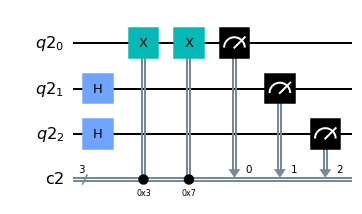

In [5]:
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)
qc.h(q[1])
qc.h(q[2])


qc.x(q[0]).c_if(c, 3) # for the 011 case
qc.x(q[0]).c_if(c, 7) # for the 111 case


qc.measure(q,c)
qc.draw(output='mpl')


# IPE

To understand the maths behind the algoritm you can check [Ch.3.5 Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html) and [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)

The motivation for this tutorial is that QPE algorithm works fine for small circuits but when the circuit starts to grow due to noise and decoherence time it doesn't work properly.

In the QPE chapter a $T$-gate is used and in the Lab4 the same gate is used so we are using a $S$-gate so there are diverse examples.

Let's build the IPE algorithm to stimate the phase of the S-gate:

The $S$-gate adds a phase of $ e^{\frac{i\pi}{2}} $ to the state $|1\rangle$:


$$ S|1\rangle = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{2}\\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= e^\frac{i\pi}{2}|1\rangle $$

First we initialize the circuit, we will need 3 counting qubits

In [6]:
c_q = 3
q = QuantumRegister(2)
c = ClassicalRegister(c_q)

qc_T = QuantumCircuit(q,c)

Then we initialize the first part of the algorithm  

In [7]:
qc_T.h(0)
qc_T.x(1)

And perform the Cu operations [Summary of Quantum Operations](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#Two-qubit-gates), in this case and because we are using the $S$-gate the $\theta$ will be $\frac{\pi}{2}$

In [8]:
## c-U^(2^t) operations (with t=m-1)
for _ in range(2**(c_q-1)):
    qc_T.cp(np.pi/2,0,1)

As you can see in the algorithm we need an x_measure, so we are going to define a function to perform the x_measure and then apply it.

In [9]:
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)
    return qc

In [10]:
x_measurement(qc_T, q[0], c[0]) 


As we want to perform an iterative algorithm we need to reset the circuit, initialize it again and perform a phase correction, the phase correction is done only if the first qubit is 1, so as we saw in the first part of this tutorial, we have to use a c_if gate with a value of 1 (1 == 001)

In [11]:
#inizialization of qubit 0
qc_T.reset(0)
qc_T.h(0)

## phase correction
qc_T.p(-np.pi/2,0).c_if(c,1) 

Again the Cu operations and the measurement

In [14]:
## c-U^(2^t) operations (with t=m-2)
for _ in range(2**(c_q-2)):
    qc_T.cp(np.pi/2,0,1)

x_measurement(qc_T, q[0], c[1]) 


Let's do all together:
- Initialize
- Phase correction for the first qubit (c_if with 1 &#8594; 001 )
- Phase correction for the second qubit (c_if with 2 or 3 &#8594; 2=010, 3=011)
- Measure

In [15]:
#inizialization of qubit 0
qc_T.reset(0)
qc_T.h(0)

### phase correction ###
qc_T.p(-np.pi/4,0).c_if(c,1) 

qc_T.p(-np.pi/2,0).c_if(c,2)
qc_T.p(-np.pi/2,0).c_if(c,3)

## c-U^(2^t) operations (with t=m-3=0)
for _ in range(2**(c_q-3)):
    qc_T.cp(np.pi/2,0,1)

## X measurement   
x_measurement(qc_T, q[0], c[2]) 




Et voilà, we can draw our circuit

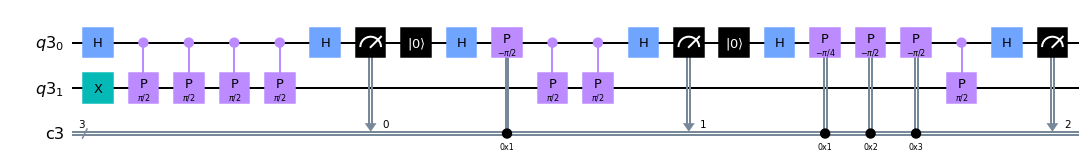

In [16]:
qc_T.draw('mpl')

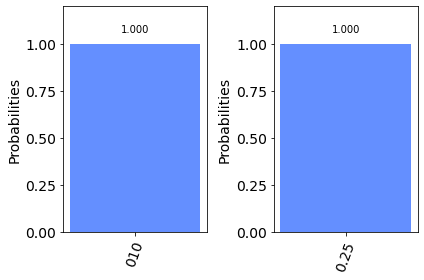

In [22]:
sim = Aer.get_backend('qasm_simulator')
count0 = execute(qc_T, sim).result().get_counts()
n=3
key_new = [str(int(key,2)/2**n) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
plt.tight_layout()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright